<a href="https://colab.research.google.com/github/yychaza14/NAIRA/blob/main/USDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
import json
from typing import Dict, Any, Optional
from datetime import datetime

class BinanceAPIError(Exception):
    """Custom exception for Binance API errors"""
    def __init__(self, code: str, message: str, message_detail: Optional[str] = None, data: Any = None):
        self.code = code
        self.message = message
        self.message_detail = message_detail
        self.data = data
        super().__init__(self.message)

class BinanceP2PAPI:
    BASE_URL = "https://p2p.binance.com/bapi/c2c/v2/friendly/c2c/adv/search"

    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'Accept': '*/*',
            'Accept-Language': 'en-US,en;q=0.9',
            'Content-Type': 'application/json',
            'Origin': 'https://p2p.binance.com',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })

    def _handle_response(self, response: requests.Response) -> Dict:
        """
        Handle API response and check for errors
        """
        try:
            data = response.json()

            if not data.get('success', False):
                raise BinanceAPIError(
                    code=data.get('code', 'unknown'),
                    message=data.get('message', 'Unknown error'),
                    message_detail=data.get('messageDetail'),
                    data=data.get('data')
                )
            return data

        except json.JSONDecodeError:
            raise BinanceAPIError(
                code='decode_error',
                message='Failed to decode API response',
                message_detail=response.text
            )

    def search_advertisements(self,
                            asset: str = "USDT",
                            fiat: str = "XAF",
                            trade_type: str = "BUY",
                            payment_method: Optional[str] = None,
                            page: int = 1,
                            rows: int = 19) -> Dict:
        """
        Search P2P advertisements on Binance

        Args:
            asset: Cryptocurrency asset (e.g., "USDT", "BTC")
            fiat: Fiat currency (e.g., "USD", "EUR")
            trade_type: "BUY" or "SELL"
            payment_method: Optional payment method
            page: Page number
            rows: Number of results per page

        Returns:
            Dict containing the search results
        """
        payload = {
            "asset": asset,
            "fiat": fiat,
            "merchantCheck": True,
            "page": page,
            "payTypes": [payment_method] if payment_method else [],
            "publisherType": None,
            "rows": rows,
            "tradeType": trade_type
        }

        try:
            response = self.session.post(self.BASE_URL, json=payload)
            response.raise_for_status()  # Raise exception for bad status codes
            return self._handle_response(response)

        except requests.exceptions.RequestException as e:
            raise BinanceAPIError(
                code='request_failed',
                message=f'Request failed: {str(e)}',
                message_detail=str(e)
            )

def main():
    api = BinanceP2PAPI()

    try:
        # Example: Search for USDT/USD buy advertisements
        result = api.search_advertisements(
            asset="USDT",
            fiat="XAF",
            trade_type="BUY",
            rows=20
        )

        # Process successful response
        if result.get('success'):
            advertisements = result.get('data', [])
            print(f"Found {len(advertisements)} advertisements:")

            for ad in advertisements:
                print(f"\nSeller: {ad.get('advertiser', {}).get('nickName')}")
                print(f"Price: {ad.get('adv', {}).get('price')} {ad.get('adv', {}).get('fiatUnit')}")
                print(f"Available: {ad.get('adv', {}).get('surplusAmount')} {ad.get('adv', {}).get('asset')}")
                print(f"Payment Methods: {', '.join(method.get('identifier') for method in ad.get('adv', {}).get('tradeMethods', []))}")

    except BinanceAPIError as e:
        print(f"API Error {e.code}: {e.message}")
        if e.message_detail:
            print(f"Details: {e.message_detail}")

    except Exception as e:
        print(f"Unexpected error: {str(e)}")

if __name__ == "__main__":
    main()

Found 20 advertisements:

Seller: ladeesse
Price: 649.18 XAF
Available: 33.63 USDT
Payment Methods: MTNMobileMoney

Seller: SUBLIMINAL_CRYPTO
Price: 649.18 XAF
Available: 247.04 USDT
Payment Methods: MTNMobileMoney, MoMoNew

Seller: FREE_CHABGE
Price: 649.19 XAF
Available: 347.09 USDT
Payment Methods: MTNMobileMoney, MoMoNew

Seller: fastserviceexchange
Price: 649.20 XAF
Available: 203.36 USDT
Payment Methods: MTNMobileMoney

Seller: BLUEPIPS FX
Price: 649.29 XAF
Available: 717.22 USDT
Payment Methods: MoMoNew

Seller: T-Eexchange
Price: 649.30 XAF
Available: 1692.35 USDT
Payment Methods: MTNMobileMoney, MoMoNew

Seller: Xchangesmart
Price: 649.39 XAF
Available: 20.04 USDT
Payment Methods: MTNMobileMoney

Seller: No-one-is-above-God
Price: 649.49 XAF
Available: 158.23 USDT
Payment Methods: MTNMobileMoney

Seller: Duc_de_Sullun
Price: 649.50 XAF
Available: 220.01 USDT
Payment Methods: MTNMobileMoney

Seller: AlienTech237
Price: 649.72 XAF
Available: 607.57 USDT
Payment Methods: MoMoNew,

In [ ]:
import requests
import json

class BinanceP2PAPI:
    BASE_URL = "https://p2p.binance.com/bapi/c2c/v2/friendly/c2c/adv/search"

    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'Accept': '*/*',
            'Accept-Language': 'en-US,en;q=0.9',
            'Content-Type': 'application/json',
            'Origin': 'https://p2p.binance.com',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })

    def search_advertisements(self,
                            asset: str = "USDT",
                            fiat: str = "XAF",
                            trade_type: str = "BUY",
                            payment_method: str = None,
                            page: int = 1,
                            rows: int = 10):
        """
        Search P2P advertisements on Binance and return raw JSON response
        """
        payload = {
            "asset": asset,
            "fiat": fiat,
            "merchantCheck": True,
            "page": page,
            "payTypes": [payment_method] if payment_method else [],
            "publisherType": None,
            "rows": rows,
            "tradeType": trade_type
        }

        try:
            response = self.session.post(self.BASE_URL, json=payload)
            response.raise_for_status()
            return response.json()

        except requests.exceptions.RequestException as e:
            return {
                "success": False,
                "code": "request_failed",
                "message": str(e),
                "data": None
            }

# Example usage
def main():
    api = BinanceP2PAPI()

    # Get raw response
    response = api.search_advertisements(
        asset="USDT",
        fiat="XAF",
        trade_type="BUY",
        rows=5
    )

    # Print formatted JSON
    print(json.dumps(response, indent=2))

if __name__ == "__main__":
    main()

{
  "code": "000000",
  "message": null,
  "messageDetail": null,
  "data": [
    {
      "adv": {
        "advNo": "13686519898942525440",
        "classify": "profession",
        "tradeType": "SELL",
        "asset": "USDT",
        "fiatUnit": "XAF",
        "advStatus": null,
        "priceType": null,
        "priceFloatingRatio": null,
        "rateFloatingRatio": null,
        "currencyRate": null,
        "price": "647.40",
        "initAmount": null,
        "surplusAmount": "127.28",
        "tradableQuantity": "127.07",
        "amountAfterEditing": null,
        "maxSingleTransAmount": "300000.00",
        "minSingleTransAmount": "15000.00",
        "buyerKycLimit": null,
        "buyerRegDaysLimit": null,
        "buyerBtcPositionLimit": null,
        "remarks": null,
        "autoReplyMsg": "",
        "payTimeLimit": 15,
        "tradeMethods": [
          {
            "payId": null,
            "payMethodId": "",
            "payType": "MoMoNew",
            "payAccou

Loading page...
Waiting for content to load...
Screenshot saved as 'bybit_page.png'
{
  "success": true,
  "data": [
    {
      "price": "1747.5 NGN\nSuper\n1553.33",
      "available": "110.7301 USDT\n30,000.00 ~ 193,500.84 NGN"
    },
    {
      "price": "1,744.00 NGN",
      "available": "10.8684 USDT\n18,835.00 ~ 18,835.00 NGN"
    },
    {
      "price": "1,744.00 NGN",
      "available": "19.9241 USDT\n20,000.00 ~ 34,747.00 NGN"
    },
    {
      "price": "1,744.00 NGN",
      "available": "11.6000 USDT\n20,230.00 ~ 20,230.00 NGN"
    },
    {
      "price": "",
      "available": ""
    },
    {
      "price": "",
      "available": ""
    },
    {
      "price": "",
      "available": ""
    },
    {
      "price": "",
      "available": ""
    },
    {
      "price": "",
      "available": ""
    },
    {
      "price": "",
      "available": ""
    },
    {
      "price": "",
      "available": ""
    }
  ],
  "message": "Data scraped successfully"
}


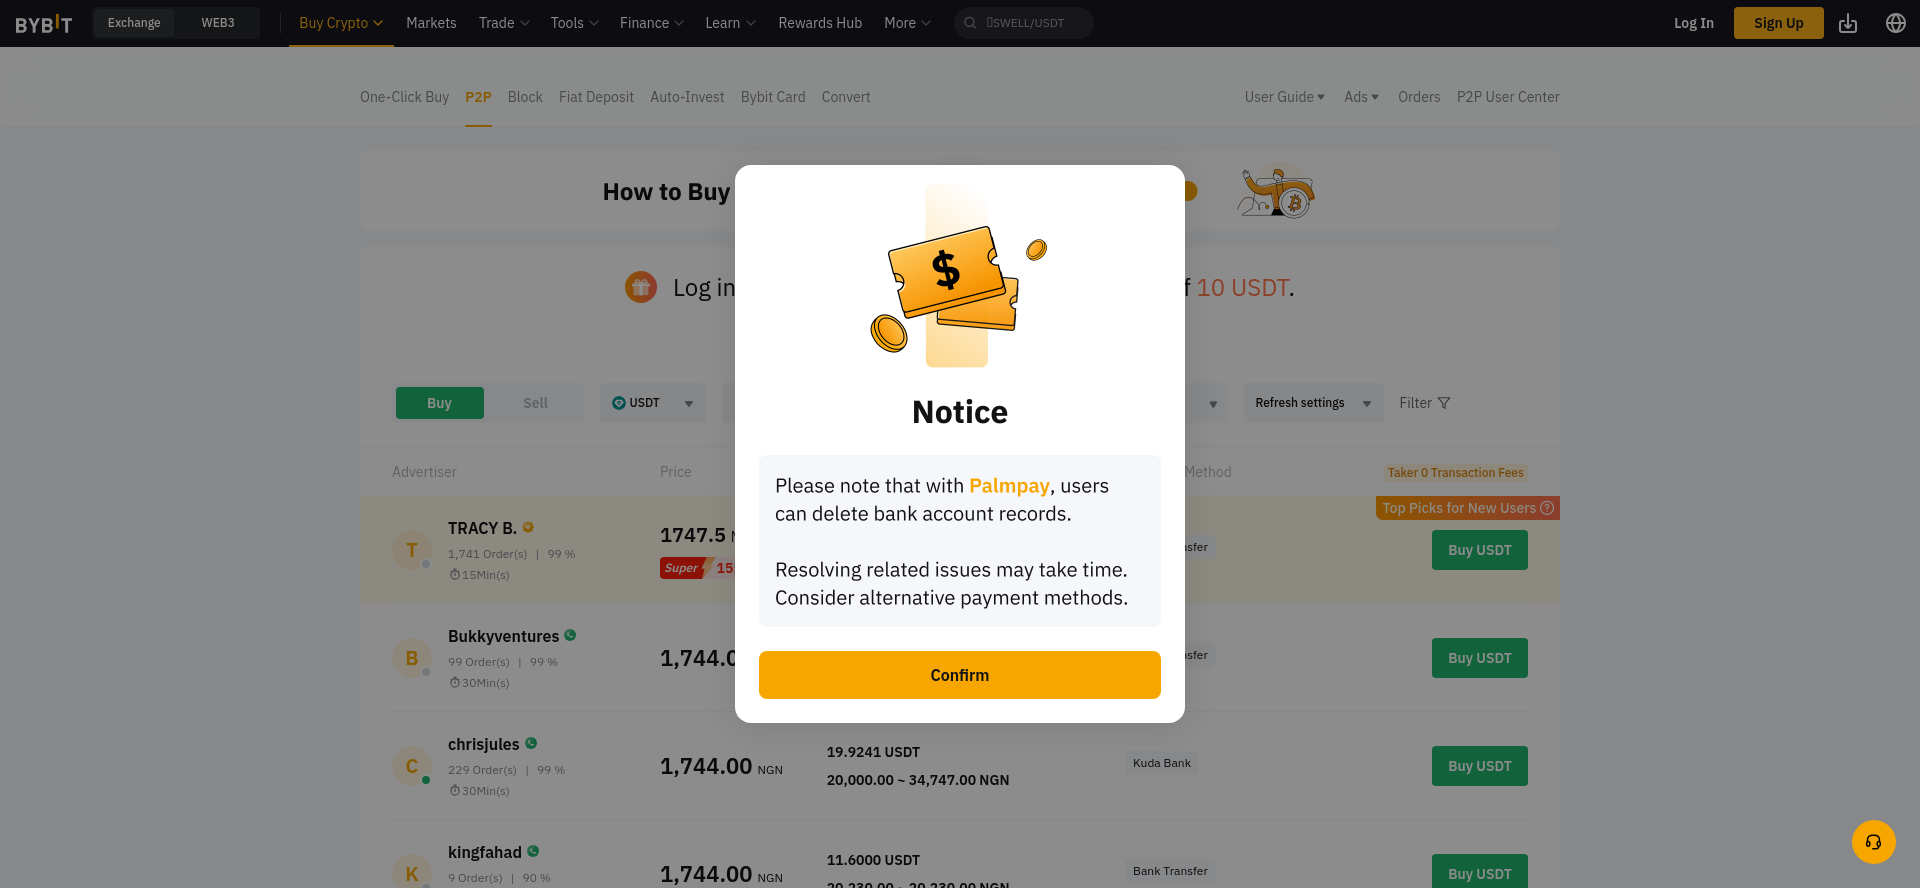

In [15]:
'''!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin'''

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import json
import time

class BybitScraper:
    def __init__(self):
        # Set up Chrome options for Colab
        chrome_options = Options()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        chrome_options.add_argument('--window-size=1920,1080')
        chrome_options.add_argument('--disable-gpu')

        # Add headers to mimic real browser
        chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")

        # Initialize the Chrome WebDriver with Colab configuration
        self.driver = webdriver.Chrome(options=chrome_options)

    def get_p2p_listings(self, token="USDT", fiat="NGN", action_type="1"):
        """
        Scrape P2P listings from Bybit website

        Args:
            token: Cryptocurrency (e.g., "USDT", "BTC")
            fiat: Fiat currency (e.g., "NGN", "USD")
            action_type: "1" for buy, "2" for sell
        """
        url = f"https://www.bybit.com/fiat/trade/otc?actionType={action_type}&token={token}&fiat={fiat}"

        try:
            print("Loading page...")
            self.driver.get(url)

            # Wait for the content to load
            print("Waiting for content to load...")
            WebDriverWait(self.driver, 90).until(
                EC.presence_of_element_located((By.TAG_NAME, "tbody"))
            )

            # Give additional time for dynamic content
            time.sleep(60)

            # Take screenshot for debugging
            self.driver.save_screenshot("/content/bybit_page.png")
            print("Screenshot saved as 'bybit_page.png'")

            # Extract all listings
            listings = []
            rows = self.driver.find_elements(By.CSS_SELECTOR, "tbody tr")

            #print(f"Found {len(rows)} listings")

            for row in rows:
                try:
                    # Extract text content with explicit waits
                    merchant = WebDriverWait(row, 10).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "td:nth-child(1)"))
                    ).text

                    price = WebDriverWait(row, 5).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "td:nth-child(2)"))
                    ).text

                    available = WebDriverWait(row, 5).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "td:nth-child(3)"))
                    ).text

                    limit = WebDriverWait(row, 5).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "td:nth-child(4)"))
                    ).text

                    payment_methods = [
                        method.get_attribute("title")
                        for method in row.find_elements(By.CSS_SELECTOR, "td:nth-child(5) img")
                    ]

                    listing = {
                        #"merchant": merchant,
                        "price": price,
                        "available": available,
                        #"limit": limit,
                        #"payment_methods": payment_methods
                    }
                    listings.append(listing)
                    #print(f"Processed listing for merchant: {merchant}")

                except Exception as e:
                    print(f"Error parsing row: {str(e)}")
                    continue

            return {
                "success": True,
                "data": listings,
                "message": "Data scraped successfully"
            }

        except Exception as e:
            return {
                "success": False,
                "data": None,
                "message": f"Error: {str(e)}"
            }

    def close(self):
        """Close the browser"""
        if self.driver:
            self.driver.quit()

# Example usage
scraper = BybitScraper()

try:
    # Get USDT/NGN buy listings
    result = scraper.get_p2p_listings(
        token="USDT",
        fiat="NGN",
        action_type="1"  # 1 for buy
    )

    # Print formatted JSON
    print(json.dumps(result, indent=2))

finally:
    scraper.close()

# Display the screenshot (if saved successfully)
from IPython.display import Image
try:
    display(Image('/content/bybit_page.png'))
except:
    print("Screenshot not available")